In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
! pip install --upgrade rasterio
! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ffpxdwsl
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ffpxdwsl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
%pip install albumentations==0.4.6

In [4]:
%pip install pyproj 
%pip install geopandas 

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # image plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300 #increase plot resolution

#Raster data handling
from PIL import Image
import skimage
from skimage import io, transform 
import rasterio as rio # geo-oriented plotting library
from rasterio import features
import cv2

#PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, Sampler # custom dataset handling
import torch.autograd.profiler as profiler # to track model inference and detect leaks
from torchvision import transforms, utils
from torch.autograd import Variable
from torch import nn
from torch.nn.modules.padding import ReplicationPad2d
import torchvision.models as models
from torch import optim
from collections import OrderedDict
import segmentation_models_pytorch as smp #semantic segmentation models and utils
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

#Augmentations
import albumentations as alb
from albumentations.pytorch import ToTensorV2

#Logging errors and progress, sending them to tg-bot
import requests
import traceback

#Other
from pathlib import Path # to have path strings as PosixPath objexts
import pathlib 
from pyproj import CRS
import geopandas as gpd # to make dataframes out of geojson files
import itertools
import re
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import gc
from timeit import default_timer as time
import copy
import json
import logging
import datetime

In [6]:
from descartes import PolygonPatch

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
gc.collect()

141

In [9]:
sample_path = Path('../train/SN7_buildings_train_sample/sample/L15-0506E-1204N_2027_3374_13')
label_csv_path = Path('../train/SN7_buildings_train_csvs/csvs/sn7_train_ground_truth_pix.csv')
output_path = Path.cwd()
output_csv_path = output_path/'output_csvs/'
Path(output_csv_path).mkdir(parents=True, exist_ok=True)

In [10]:
df = pd.read_csv(label_csv_path)

In [11]:
df.head()

,filename,id,geometry
0,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,91,"POLYGON ((814.9857745971531 845.6005742002744,..."
1,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1452,"POLYGON ((886.3093001581728 842.7000443374272,..."
2,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1616,"POLYGON ((930.1175056053326 840.4646877695341,..."
3,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,950,"POLYGON ((923.3884236379527 840.6308379401453,..."
4,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1765,"POLYGON ((926.2129765632562 838.8862611351069,..."


In [12]:
def extract_date(string):
    pattern = r'(\d+)'
    match = re.findall(pattern=pattern,string=string)
    return (match[0],match[1])

In [13]:
def extract_file_id(string):
    pattern = r'_(L.+)'
    match = re.findall(pattern=pattern,string=string)
    return match[0]

In [15]:



df['year'],df['month'] = zip(*df['filename'].progress_map(extract_date))

  0%|          | 0/6664652 [00:00<?, ?it/s]

In [16]:
import pandas as pd 
import re
from pathlib import Path
import shapely
import geopandas as gpd
from tqdm.notebook import tqdm
tqdm.pandas();

In [17]:
df['file_id'] = df['filename'].progress_map(extract_file_id)

  0%|          | 0/6664652 [00:00<?, ?it/s]

In [18]:
df.head()

,filename,id,geometry,year,month,file_id
0,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,91,"POLYGON ((814.9857745971531 845.6005742002744,...",2018,01,L15-0331E-1257N_1327_3160_13
1,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1452,"POLYGON ((886.3093001581728 842.7000443374272,...",2018,01,L15-0331E-1257N_1327_3160_13
2,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1616,"POLYGON ((930.1175056053326 840.4646877695341,...",2018,01,L15-0331E-1257N_1327_3160_13
3,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,950,"POLYGON ((923.3884236379527 840.6308379401453,...",2018,01,L15-0331E-1257N_1327_3160_13
4,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1765,"POLYGON ((926.2129765632562 838.8862611351069,...",2018,01,L15-0331E-1257N_1327_3160_13


In [19]:
df['year'].value_counts()

2019    3218079
2018    3108106
2020     251332
2017      87135
Name: year, dtype: int64

In [20]:
df['month'].value_counts()

01    768692
04    576131
03    574213
11    568068
02    536911
10    535662
05    532413
09    530252
12    521228
08    520019
06    509831
07    491232
Name: month, dtype: int64

In [21]:
gdf = gpd.GeoDataFrame(df)
gdf['geometry'] = gdf['geometry'].progress_map(shapely.wkt.loads)

  0%|          | 0/6664652 [00:00<?, ?it/s]

In [22]:
print('data type of geometry column before conversion: ', df['geometry'].dtype)
print('data type of geometry column after conversion: ', gdf['geometry'].dtype)

data type of geometry column before conversion:  geometry
data type of geometry column after conversion:  geometry


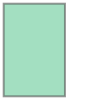

POLYGON ((814.9857745971531 845.6005742002744, 810.2228029975668 845.6005742002744, 810.2228029975668 838.4007334102644, 814.9857745971531 838.4007334102644, 814.9857745971531 845.6005742002744))


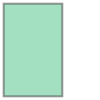

In [23]:
display(df['geometry'][0])
print(gdf['geometry'][0])
display(gdf['geometry'][1])

In [24]:
gdf.to_file(output_csv_path/"global_geodataframe.gpkg", driver="GPKG")